# distilbert hyperparameters
In this experiment, we will create two baseline machine learning models to predict the values, providing a foundation for future iterations.
Now that we have everything ready, we will export the dataset.

- **MODEL_NAME**: `"distilbert-base-uncased"`
- **NAME_EXPERIMENTS**: `"Fake news comments"`
- **DATASET_NAME**: `"X_train_cleaned_2"`
- **HYPERPARAMETERS_EXPERIMENTS**: `20`
- **BATCH_SIZE**: `12`
- **NUM_LABELS**: `1`
- **EPOCHS**: `3`
- **THRESHOLD_PROBABILITIES_MODEL**: `0.5`
- **COMMENTS**: `"Some hyperparameter tuning with the clean dataset where we take out some values"`
- **PATIENCE_EARLY_STOP**: `3`
- **LEARNING_RATE**: `1e-10 to 1e-2`
- **WEIGHT_DECAY**: `1e-12 to 1e-2`
- **DROPOUT_VALUE**: `0.1 to 0.3`
- **WARMUP_RATIO**: `0.0 to 0.2`
- **OPTIMIZER_NAME**: `"AdamW"`, `"SGD"`, `"RMSprop"`


Also, we will be adding just 30% of the training dataset, but for the training we had all the dataset.

In [ ]:
%%capture
!pip install mlflow dagshub wandb optuna

In [ ]:
# Standard Library Imports
import math
import os
from typing import Dict, List

# Third-party Libraries
import mlflow
import mlflow.pytorch
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import wandb
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from torch.optim import AdamW, RMSprop, SGD
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud

# Hugging Face Transformers
from transformers import (
    AdamW,
    AutoModel,
    AutoTokenizer,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup
)

# PyTorch Libraries
import torch.nn as nn
import torch.nn.functional as F


# import google drive
from google.colab import drive, files
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""Import the modules from google colab"""
import sys
PATH_helper = "/content/drive/MyDrive/turing_college_experiments/16/helper"
sys.path.append(PATH_helper)
# Custom imports
from helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)

"""
Verify the cores and gpu in the colab
"""
num_cores = os.cpu_count()  # Get the number of CPU cores
print(f'Number of available CPU cores: {num_cores}')
NUM_WORKERS = num_cores - 1
print(f'Setting num_workers to: {NUM_WORKERS}')

num_gpus_colab = torch.cuda.device_count()
GPU_LIST = [torch.cuda.get_device_name(i) for i in range(num_gpus_colab)]
NUM_WORKERS, GPU_LIST

enable_code_paths = True
enable_block = False

# weight and biases
wandb.login()

# ml versioning control
import dagshub
import mlflow
import mlflow.sklearn
dagshub.init(repo_owner='auszed', repo_name='Experiments_fake_news', mlflow=True)

# tracking experiments
os.environ['MLFLOW_TRACKING_USERNAME'] = 'auszed'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4390ce1796189f46f62a5e643463dcaffede3ebf'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/auszed/Experiments_fake_news.mlflow'


# Download the stopwords if you haven't already
nltk.download('stopwords')

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
X_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_train_cleaned_2.csv")
y_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_train.csv")
X_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_val_cleaned_2.csv")
y_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_test_cleaned_2.csv")
y_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_test.csv")

X_train = X_train[["title_text_join"]]
X_val = X_val[["title_text_join"]]
X_test = X_test[["title_text_join"]]

print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )
theme_color

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of available CPU cores: 12
Setting num_workers to: 11


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=dbcdb5c9-1128-4c5c-8def-202ca4824ed2&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=cc9f9556bb3545555109c56f5e451050c0b73aa24f025a565d1c7b2f0fc1fa8c




Accessing as auszed

Initialized MLflow to track repo "auszed/Experiments_fake_news"

Repository auszed/Experiments_fake_news initialized!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(26759, 1) (26759, 1)
(5734, 1) (5734, 1)
(5735, 1) (5735, 1)


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
#@title sample dataset for experiments
# sample size
enable_samples: bool = True #@param
SAMPLE_PERCENTAGE_X_train = 0.3 #@param
SAMPLE_PERCENTAGE_X_val = 1 #@param
SAMPLE_PERCENTAGE_X_test = 1 #@param

MODEL_NAME = "distilbert-base-uncased" #@param
VERSION_MODEL = "006" #@param
NAME_EXPERIMENTS = "Fake news comments" #@param
DATASET_NAME = "X_train_cleaned_2" #@param title
HYPERPARAMETERS_EXPERIMENTS = 20 #@param
BATCH_SIZE = 12 #@param
NUM_LABELS = 1 #@param
EPOCHS = 3 #@param
THRESHOLD_PROBABILITIES_MODEL = 0.5 #@param

# COMMENTS = "Some hyperparameter tunning with the clean dataset where we take out some values" #@param
COMMENTS = "Experiment" #@param
PATIENCE_EARLY_STOP = 3 #@param
LEARNING_RATE_INIT = 1e-10 #@param
LEARNING_RATE_END = 1e-6 #@param
WEIGHT_DECAY_INIT = 1e-12 #@param
WEIGHT_DECAY_END = 1e-2 #@param
DROPOUT_VALUE_INIT = 0.1 #@param
DROPOUT_VALUE_END = 0.3 #@param
WARMUP_RATIO_INIT = 0.0 #@param
WARMUP_RATIO_END = 0.2 #@param
OPTIMIZER_NAME_1 = "AdamW" #@param
OPTIMIZER_NAME_2 = "SGD" #@param
OPTIMIZER_NAME_3 = "RMSprop" #@param

URL_SAVE_MODEL = f"/content/drive/MyDrive/turing_college_experiments/16/model_save/{MODEL_NAME}_{VERSION_MODEL}.pth"

if enable_samples:
    # Concatenating the datasets
    concat_values_train = pd.concat([X_train, y_train], axis=1)
    concat_values_val = pd.concat([X_val, y_val], axis=1)
    concat_values_test = pd.concat([X_test, y_test], axis=1)

    # Sampling the datasets
    concat_values_train = concat_values_train.sample(frac=SAMPLE_PERCENTAGE_X_train, random_state=42)
    concat_values_val = concat_values_val.sample(frac=SAMPLE_PERCENTAGE_X_val, random_state=42)
    concat_values_test = concat_values_test.sample(frac=SAMPLE_PERCENTAGE_X_test, random_state=42)

    # Resetting the index without using inplace
    concat_values_train = concat_values_train.reset_index(drop=True)
    concat_values_val = concat_values_val.reset_index(drop=True)
    concat_values_test = concat_values_test.reset_index(drop=True)

    # Extracting features and targets
    X_train = pd.DataFrame(concat_values_train["title_text_join"])
    X_val = pd.DataFrame(concat_values_val["title_text_join"])
    X_test = pd.DataFrame(concat_values_test["title_text_join"])

    y_train = pd.DataFrame(concat_values_train["target_variable"])
    y_val = pd.DataFrame(concat_values_val["target_variable"])
    y_test = pd.DataFrame(concat_values_test["target_variable"])


print("TRAIN Dataset: {}".format(X_train.shape))
print("VALIDATION Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))
print("TRAIN Dataset y: {}".format(y_train.shape))
print("VALIDATION Dataset y: {}".format(y_val.shape))
print("TEST Dataset y: {}".format(y_test.shape))

sample_data = 5 #@param
X_train.sample(sample_data)

TRAIN Dataset: (8028, 1)
VALIDATION Dataset: (5734, 1)
TEST Dataset: (5735, 1)
TRAIN Dataset y: (8028, 1)
VALIDATION Dataset y: (5734, 1)
TEST Dataset y: (5735, 1)


,title_text_join
2447,tiffany co. takes big risk sides controversial...
505,rob reiner best response going mexico going me...
1049,flashback : bernie sanders ’ socialist democra...
1568,eu mps threaten cambodia aid trade crackdownph...
2141,black racists tried shut threatening intimidat...


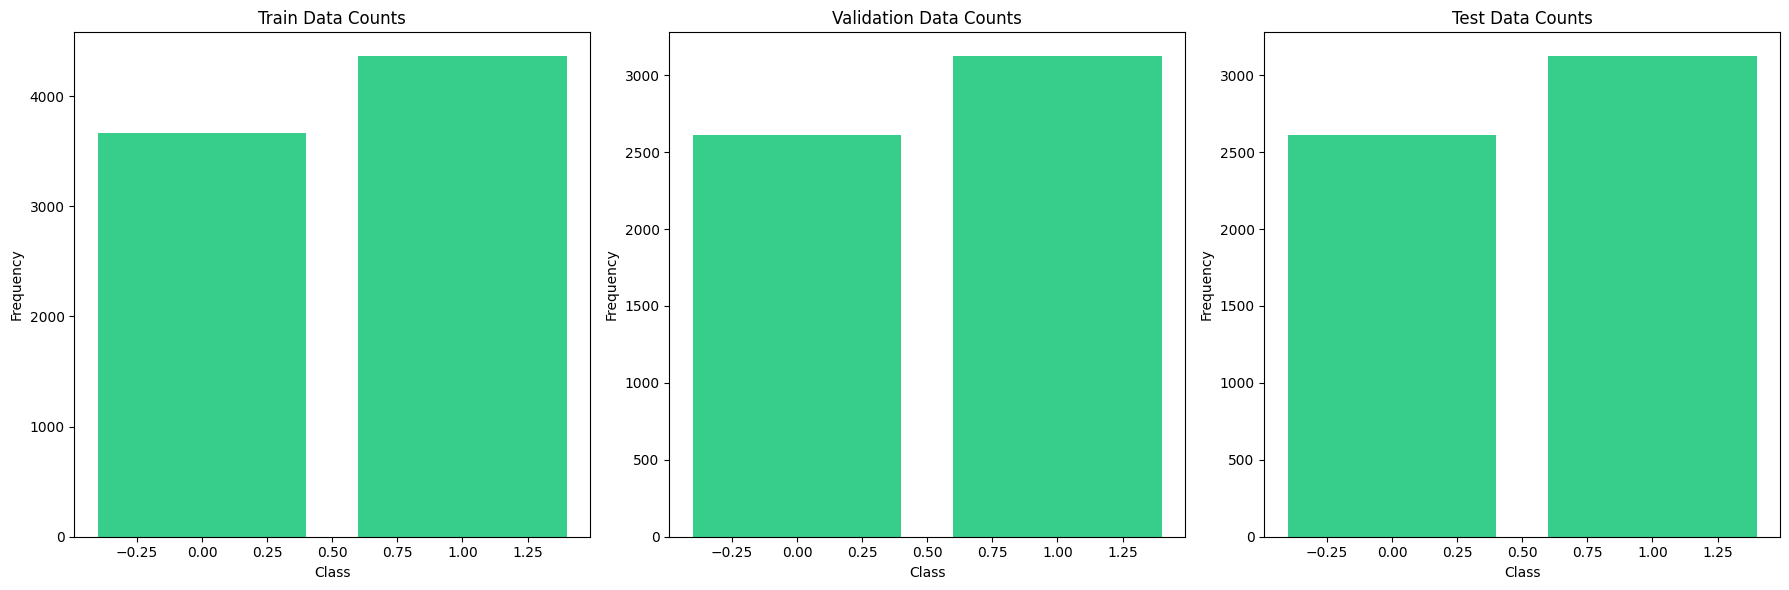

In [ ]:
#@title Split of the dataset
# Get counts for each dataset
train_counts = y_train.value_counts().reset_index()
val_counts = y_val.value_counts().reset_index()
test_counts = y_test.value_counts().reset_index()
train_counts.columns = ['Class', 'Frequency']
val_counts.columns = ['Class', 'Frequency']
test_counts.columns = ['Class', 'Frequency']

real_values = train_counts['Frequency'][0]
fake_values = train_counts['Frequency'][1]
total_values = train_counts['Frequency'].sum()
real_percentage = (real_values / total_values)
fake_percentage = (fake_values / total_values)

normalized_weights = torch.tensor([real_percentage, fake_percentage], dtype=torch.float)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot for train data
ax[0].bar(train_counts['Class'], train_counts['Frequency'])
ax[0].set_title('Train Data Counts')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Plot for validation data
ax[1].bar(val_counts['Class'], val_counts['Frequency'])
ax[1].set_title('Validation Data Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

# Plot for test data
ax[2].bar(test_counts['Class'], test_counts['Frequency'])
ax[2].set_title('Test Data Counts')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
#@title Dataloader
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, comment_str_title: str, tokenizer, target_variable: pd.DataFrame, max_token_len=256):
        # assert isinstance(dataframe, pd.DataFrame), "dataframe needs to be a pandas DataFrame for this code to work"
        # assert isinstance(target_variable, pd.DataFrame), "target_variable needs to be a pandas DataFrame for this code to work"

        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.target_variable = target_variable
        self.comment_str_title = comment_str_title

    def chunk_text(self, text, max_length, stride):
        tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=None,
            truncation=False,
            return_attention_mask=False,
            return_token_type_ids=False
        )['input_ids']

        chunks = []
        for i in range(0, len(tokens), stride):
            chunk = tokens[i:i + max_length]
            if len(chunk) < max_length:
                chunk += [self.tokenizer.pad_token_id] * (max_length - len(chunk))  # Padding
            chunks.append(chunk)
        return chunks

    def __len__(self):
        """Length of the dataset"""
        return len(self.dataframe)

    def __getitem__(self, index):
        """Get a single item"""
        data_row = self.dataframe.iloc[index]
        comment = str(data_row[self.comment_str_title])
        data_row_target = torch.tensor(self.target_variable.iloc[index].values, dtype=torch.float)

        # Split the comment into chunks
        chunks = self.chunk_text(comment, max_length=self.max_token_len, stride=self.max_token_len // 2)

        input_ids = []
        attention_masks = []

        for chunk in chunks:
            # Here, `chunk` is already tokenized, so we directly create tensors
            tokens = {
                "input_ids": torch.tensor(chunk, dtype=torch.long),
                "attention_mask": torch.tensor([1 if id != self.tokenizer.pad_token_id else 0 for id in chunk], dtype=torch.long)
            }
            input_ids.append(tokens["input_ids"])
            attention_masks.append(tokens["attention_mask"])

        return {
            "input_ids": torch.stack(input_ids),
            "attention_masks": torch.stack(attention_masks),
            "labels": data_row_target
        }

# Model configuration
model_name = MODEL_NAME
tokenizer_model = AutoTokenizer.from_pretrained(model_name)

# dataloaders for training, val, test
dataset_loader_X_train = CustomDataset(
    dataframe=X_train,
    comment_str_title='title_text_join',
    target_variable=y_train,
    tokenizer=tokenizer_model,
    max_token_len=256
)
dataset_loader_X_val = CustomDataset(
    dataframe=X_val,
    comment_str_title='title_text_join',
    target_variable=y_val,
    tokenizer=tokenizer_model,
    max_token_len=256
)
dataset_loader_X_test = CustomDataset(
    dataframe=X_test,
    comment_str_title='title_text_join',
    target_variable=y_test,
    tokenizer=tokenizer_model,
    max_token_len=256
)

# Test the dataset
print("Dataset train length:", len(dataset_loader_X_train))
print("Dataset val length:", len(dataset_loader_X_val))
print("Dataset test length:", len(dataset_loader_X_test))
sample = dataset_loader_X_train[0]
print("Sample input IDs shape:", sample["input_ids"].shape)
print("Sample attention masks shape:", sample["attention_masks"].shape)
print("Sample labels:", sample["labels"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (530 > 512). Running this sequence through the model will result in indexing errors


Dataset train length: 8028
Dataset val length: 5734
Dataset test length: 5735
Sample input IDs shape: torch.Size([5, 256])
Sample attention masks shape: torch.Size([5, 256])
Sample labels: tensor([1.])


In [ ]:
# value_review = 22
# print(X_train.iloc[value_review])
# print(y_train.iloc[value_review])
# dataset_loader_X_train.__getitem__(value_review)

In [ ]:
#@title Batches
def custom_collate_fn(batch: List[Dict]) -> Dict:
    """
    Custom collate function to handle variable number of chunks per sample.
    """
    # Get the max number of chunks in this batch
    max_chunks = max(sample["input_ids"].size(0) for sample in batch)

    # Get batch size and sequence length
    batch_size = len(batch)
    seq_length = batch[0]["input_ids"].size(1)

    # Initialize tensors to hold padded data
    padded_input_ids = torch.zeros((batch_size, max_chunks, seq_length), dtype=torch.long)
    padded_attention_masks = torch.zeros((batch_size, max_chunks, seq_length), dtype=torch.long)

    # Collect labels
    labels = torch.stack([sample["labels"] for sample in batch])

    # Create chunk attention mask to identify valid chunks
    chunk_attention_mask = torch.zeros((batch_size, max_chunks), dtype=torch.long)

    # Fill in the tensors with actual data
    for i, sample in enumerate(batch):
        num_chunks = sample["input_ids"].size(0)
        padded_input_ids[i, :num_chunks, :] = sample["input_ids"]
        padded_attention_masks[i, :num_chunks, :] = sample["attention_masks"]
        chunk_attention_mask[i, :num_chunks] = 1

    return {
        "input_ids": padded_input_ids,
        "attention_masks": padded_attention_masks,
        "chunk_attention_mask": chunk_attention_mask,
        "labels": labels
    }


# Create DataLoader with custom collate function
train_loader = DataLoader(
    dataset=dataset_loader_X_train,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,  # Adjust based on your CPU cores
    pin_memory=True,  # Set to True if using GPU
    drop_last=True
)
val_loader = DataLoader(
    dataset=dataset_loader_X_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)
test_loader = DataLoader(
    dataset=dataset_loader_X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

print(len(train_loader), "train_loader batch")
print(len(val_loader), "val_loader batch")
print(len(test_loader), "test_loader batch")

669 train_loader batch
477 val_loader batch
477 test_loader batch


In [ ]:
#@title Model architecture

class ClassifierModel(nn.Module):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.config = config

        # Pretrained model
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)

        # Layers
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])

        # Initialize weights
        nn.init.xavier_uniform_(self.hidden.weight)  # Use Xavier initialization
        nn.init.zeros_(self.hidden.bias)  # Initialize bias to zero
        nn.init.xavier_uniform_(self.classification.weight)  # Use Xavier initialization
        nn.init.zeros_(self.classification.bias)  # Initialize bias to zero

        # Loss function
        self.loss_function = nn.BCEWithLogitsLoss()

        # Dropout
        self.dropout = nn.Dropout(config['dropout_vals'])

    def forward(self, input_ids, attention_mask, chunk_attention_mask=None):
        batch_size, num_chunks, seq_length = input_ids.size()
        input_ids = input_ids.view(-1, seq_length)
        attention_mask = attention_mask.view(-1, seq_length)

        # Forward pass through the pretrained model
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        pooled_output = pooled_output.view(batch_size, num_chunks, -1)
        if chunk_attention_mask is not None:
            chunk_attention_mask = chunk_attention_mask.float().unsqueeze(-1)
            pooled_output = (pooled_output * chunk_attention_mask).sum(dim=1) / chunk_attention_mask.sum(dim=1).clamp(min=1)
        else:
            pooled_output = pooled_output.mean(dim=1)

        # Classification layers
        pooled_output = self.dropout(pooled_output)
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = F.normalize(pooled_output)
        logits = self.classification(pooled_output)
        logits = F.sigmoid(logits)

        return logits



print("y_train shape:", y_train.shape)
print("Sample label:", y_train.iloc[0])

config = {
    "model_name": MODEL_NAME,
    "n_labels": NUM_LABELS,
    "lr": LEARNING_RATE_INIT,
    "w_decay": WEIGHT_DECAY_INIT,
    "dropout_vals": DROPOUT_VALUE_INIT,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "train_size": len(dataset_loader_X_train),
    "warmup": WARMUP_RATIO_INIT
}


# Reinitialize the model with the updated config
model = ClassifierModel(config)
model.to(device)
model

y_train shape: (8028, 1)
Sample label: target_variable    1
Name: 0, dtype: int64


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

ClassifierModel(
  (pretrained_model): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (l

In [ ]:
# Freeze all layers initially
for param in model.pretrained_model.parameters():
    param.requires_grad = False

# Enable only the 5th layer (index 4, zero-based indexing)
layer_idx = 5
for param in model.pretrained_model.transformer.layer[layer_idx].parameters():
    param.requires_grad = True

# Verify which layers are trainable
print("Trainable Parameters:")
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

Trainable Parameters:
pretrained_model.embeddings.word_embeddings.weight: Frozen
pretrained_model.embeddings.position_embeddings.weight: Frozen
pretrained_model.embeddings.LayerNorm.weight: Frozen
pretrained_model.embeddings.LayerNorm.bias: Frozen
pretrained_model.transformer.layer.0.attention.q_lin.weight: Frozen
pretrained_model.transformer.layer.0.attention.q_lin.bias: Frozen
pretrained_model.transformer.layer.0.attention.k_lin.weight: Frozen
pretrained_model.transformer.layer.0.attention.k_lin.bias: Frozen
pretrained_model.transformer.layer.0.attention.v_lin.weight: Frozen
pretrained_model.transformer.layer.0.attention.v_lin.bias: Frozen
pretrained_model.transformer.layer.0.attention.out_lin.weight: Frozen
pretrained_model.transformer.layer.0.attention.out_lin.bias: Frozen
pretrained_model.transformer.layer.0.sa_layer_norm.weight: Frozen
pretrained_model.transformer.layer.0.sa_layer_norm.bias: Frozen
pretrained_model.transformer.layer.0.ffn.lin1.weight: Frozen
pretrained_model.tran

In [ ]:
def pytorch_metrics_calculations(all_labels, all_preds):
    """Convert to pytorch tensors if not already"""

    # convert to bool
    all_preds = torch.tensor(all_preds, dtype=torch.bool)
    all_labels = torch.tensor(all_labels, dtype=torch.bool)

    # predictions
    true_positives = torch.logical_and(all_preds == 1, all_labels == 1).sum().float()
    predicted_positives = (all_preds == 1).sum().float()
    actual_positives = (all_labels == 1).sum().float()

    # Calculate accuracy
    accuracy = (all_preds == all_labels).float().mean()

    # precision and recall
    precision = true_positives / predicted_positives if predicted_positives > 0 else torch.tensor(0.0)
    recall = true_positives / actual_positives if actual_positives > 0 else torch.tensor(0.0)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)

    return accuracy, f1, precision, recall, true_positives, predicted_positives, actual_positives

def train_model(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        if len(batch['input_ids']) < dataloader.batch_size:
            break

        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        chunk_attention_mask = batch['chunk_attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_masks, chunk_attention_mask)
        loss = model.loss_function(logits, labels)
        loss.backward()

        optimizer.step()


        total_loss += loss.item()
        # preds = (torch.sigmoid(logits) > THRESHOLD_PROBABILITIES_MODEL).float()
        preds = (logits > THRESHOLD_PROBABILITIES_MODEL).float()

        all_preds.extend(preds.squeeze().tolist())
        all_labels.extend(labels.squeeze().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy, f1, _, _, _, _, _ = pytorch_metrics_calculations(all_labels, all_preds)
    return avg_loss, accuracy, f1

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_predict_prob = [], [], []


    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_masks'].to(device)
            chunk_attention_mask = batch['chunk_attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            logits = model(input_ids, attention_masks, chunk_attention_mask)
            # preds = (torch.sigmoid(logits) > THRESHOLD_PROBABILITIES_MODEL).float()
            preds = (logits > THRESHOLD_PROBABILITIES_MODEL).float()
            all_preds.extend(preds.squeeze().tolist())
            all_labels.extend(labels.squeeze().tolist())
            all_predict_prob.extend(logits.squeeze().tolist())

    accuracy, f1, _, _, _, _, _ = pytorch_metrics_calculations(all_labels, all_preds)
    return accuracy, f1, all_preds, all_labels, all_predict_prob

In [ ]:
def objective(trial):
    """hyperparameters for the training models"""
    lr = trial.suggest_float("lr", LEARNING_RATE_INIT, LEARNING_RATE_END, step=(LEARNING_RATE_END - LEARNING_RATE_INIT) / 4, log=False)
    w_decay = trial.suggest_float("w_decay", WEIGHT_DECAY_INIT, WEIGHT_DECAY_END, step=(WEIGHT_DECAY_END - WEIGHT_DECAY_INIT) / 4, log=False)
    dropout_vals = trial.suggest_float("dropout_vals", DROPOUT_VALUE_INIT, DROPOUT_VALUE_END, log=False)
    warmup = trial.suggest_float("warmup", WARMUP_RATIO_INIT, WARMUP_RATIO_END, log=False)
    optimizer_name = trial.suggest_categorical("optimizer_name", [OPTIMIZER_NAME_1, OPTIMIZER_NAME_2, OPTIMIZER_NAME_3])

    # metric to optimize
    best_f1 = 0
    early_stop_counter = 0

    # Update config with trial values
    config = {
        "model_name": MODEL_NAME,
        "lr": lr,
        "w_decay": w_decay,
        "dropout_vals": dropout_vals,
        "batch_size": BATCH_SIZE,
        "warmup": warmup,
        "epochs": EPOCHS,
        "train_size": len(dataset_loader_X_train)
    }

    # Select optimizer
    if optimizer_name == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'])
    elif optimizer_name == "SGD":
        optimizer = SGD(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'], momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'])

    total_steps = config['train_size'] // config['batch_size']
    warmup_steps = int(total_steps * config['warmup'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    wandb.init(
        project=NAME_EXPERIMENTS,
        config={
            "model_name": config['model_name'],
            "learning_rate": config['lr'],
            "batch_size": config['batch_size'],
            "dropout": config['dropout_vals'],
            "epochs": config['epochs'],
            "weight_decay": config['w_decay'],
            "warmup": config['warmup'],
            "dataset": DATASET_NAME,
            "optimizer": optimizer_name,
            "COMMENTS": COMMENTS
        },
        name=f"training_{NAME_EXPERIMENTS}_trial_{trial.number}"
    )

    # Training loop
    with mlflow.start_run(run_name = "roberta_model"):
        mlflow.log_params({"model_name": config['model_name'],
                        "learning_rate": config['lr'],
                        "batch_size": config['batch_size'],
                        "dropout": config['dropout_vals'],
                        "epochs": config['epochs'],
                        "learning_rate": config['lr'],
                        "weight_decay": config['w_decay'],
                        "warmup": config['warmup'],
                        "dataset":  DATASET_NAME,
                        "optimizer": optimizer_name
                        })

        # running the epochs
        for epoch in range(config['epochs']):
            train_loss, train_accuracy, train_f1 = train_model(model, train_loader, optimizer, scheduler, device)
            print(f"Epoch {epoch+1}: Train Loss={train_loss}, Accuracy={train_accuracy}, F1 Score={train_f1}")
            val_accuracy, val_f1, _, _, _  = evaluate_model(model, val_loader, device)
            print(f"Epoch {epoch+1}: Accuracy={val_accuracy}, F1 Score={val_f1}")
            scheduler.step()

            # Log metrics to MLflow
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "train_f1": train_f1,
                "val_accuracy": val_accuracy,
                "val_f1": val_f1
            }, step=epoch)

            # log for weight and biases
            wandb.log({
                "epochs": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "train_f1": train_f1,
                "val_accuracy": val_accuracy,
                "val_f1": val_f1
            })

            # choose the best metric
            best_f1 = max(best_f1, val_f1)

            # Early stopping logic
            if val_f1 > best_f1:
                best_f1 = val_f1  # Update the best F1 score
                early_stop_counter = 0  # Reset the counter
                # Save the best model
                torch.save(model.state_dict(), URL_SAVE_MODEL)
            else:
                early_stop_counter += 1
                print(f"Early stopping counter: {early_stop_counter}/{PATIENCE_EARLY_STOP}")

            if early_stop_counter >= PATIENCE_EARLY_STOP:
                print("Early stopping triggered. Stopping training.")
                break

        # Log the model
        mlflow.pytorch.log_model(model, f"{MODEL_NAME}_{VERSION_MODEL}")


    # close the services
    wandb.finish()
    torch.save(model.state_dict(), URL_SAVE_MODEL)
    return best_f1

# Run the Optuna study
study = optuna.create_study(direction="maximize")
study_optimization = study.optimize(objective, n_trials= HYPERPARAMETERS_EXPERIMENTS)


[I 2025-01-15 05:48:40,798] A new study created in memory with name: no-name-fb49a1b7-ac1f-48e8-b867-31d3ed820599
wandb: Currently logged in as: hannsflip (hannsflip-none). Use `wandb login --relogin` to force relogin


Epoch 1: Train Loss=0.7015981377507539, Accuracy=0.5261584520339966, F1 Score=0.37557452917099
Epoch 1: Accuracy=0.5288259983062744, F1 Score=0.3888511061668396
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7016410440963836, Accuracy=0.5236671566963196, F1 Score=0.3767927289009094
Epoch 2: Accuracy=0.5284765958786011, F1 Score=0.3883979022502899
Early stopping counter: 2/3
Epoch 3: Train Loss=0.701679926103897, Accuracy=0.514449417591095, F1 Score=0.36098361015319824
Epoch 3: Accuracy=0.5281271934509277, F1 Score=0.38822194933891296
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 06:06:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 06:07:06 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 06:07:06 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/c86a8195108c4e34893acb6f7fdd9814
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▇▁
train_f1,▇█▁
train_loss,▁▅█
val_accuracy,█▅▁
val_f1,█▃▁
epochs,3
train_accuracy,0.51445
train_f1,0.36098
train_loss,0.70168
val_accuracy,0.52813


[I 2025-01-15 06:07:53,314] Trial 0 finished with value: 0.3888511061668396 and parameters: {'lr': 5.0005e-07, 'w_decay': 0.0050000000005, 'dropout_vals': 0.2769435872912711, 'warmup': 0.0810398550613537, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 0.3888511061668396.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss=0.7016106467075947, Accuracy=0.5227952003479004, F1 Score=0.3751427233219147
Epoch 1: Accuracy=0.5286512970924377, F1 Score=0.3890398442745209
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7015957353895556, Accuracy=0.5171898603439331, F1 Score=0.3563600182533264
Epoch 2: Accuracy=0.526380181312561, F1 Score=0.3607639670372009
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7015028112137799, Accuracy=0.5061036348342896, F1 Score=0.31436970829963684
Epoch 3: Accuracy=0.519741415977478, F1 Score=0.3063335716724396
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 06:25:58 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 06:26:09 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 06:26:09 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/64f458ae88b04e498f42e2491ae2c329
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▆▁
train_f1,█▆▁
train_loss,█▇▁
val_accuracy,█▆▁
val_f1,█▆▁
epochs,3
train_accuracy,0.5061
train_f1,0.31437
train_loss,0.7015
val_accuracy,0.51974


[I 2025-01-15 06:26:43,778] Trial 1 finished with value: 0.3890398442745209 and parameters: {'lr': 5.0005e-07, 'w_decay': 1e-12, 'dropout_vals': 0.11972520782208591, 'warmup': 0.141962425638116, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.701413344641972, Accuracy=0.5021175742149353, F1 Score=0.2762990891933441
Epoch 1: Accuracy=0.5199161171913147, F1 Score=0.30641090869903564
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7014264003756513, Accuracy=0.5112107396125793, F1 Score=0.2995359003543854
Epoch 2: Accuracy=0.519741415977478, F1 Score=0.30528178811073303
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7014281808082655, Accuracy=0.509093165397644, F1 Score=0.29284045100212097
Epoch 3: Accuracy=0.519217312335968, F1 Score=0.3039959669113159
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 06:44:55 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 06:45:07 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 06:45:07 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/3a5e0ad9f8a642558a9a9edb1b831d7f
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁█▆
train_f1,▁█▆
train_loss,▁▇█
val_accuracy,█▆▁
val_f1,█▅▁
epochs,3
train_accuracy,0.50909
train_f1,0.29284
train_loss,0.70143
val_accuracy,0.51922


[I 2025-01-15 06:45:41,264] Trial 2 finished with value: 0.30641090869903564 and parameters: {'lr': 7.50025e-07, 'w_decay': 0.00250000000075, 'dropout_vals': 0.18336866880862696, 'warmup': 0.03550415579537112, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7014114283838258, Accuracy=0.5123318433761597, F1 Score=0.29472166299819946
Epoch 1: Accuracy=0.5193920135498047, F1 Score=0.3044247627258301
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7013899860360697, Accuracy=0.5118336081504822, F1 Score=0.2862866520881653
Epoch 2: Accuracy=0.5145003199577332, F1 Score=0.2776189148426056
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7012623072739674, Accuracy=0.5074738264083862, F1 Score=0.2545248866081238
Epoch 3: Accuracy=0.50104820728302, F1 Score=0.2153846174478531
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 07:03:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 07:04:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 07:04:05 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/a1e3fe82637140d3854031380a7595ba
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▇▁
train_f1,█▇▁
train_loss,█▇▁
val_accuracy,█▆▁
val_f1,█▆▁
epochs,3
train_accuracy,0.50747
train_f1,0.25452
train_loss,0.70126
val_accuracy,0.50105


[I 2025-01-15 07:04:42,159] Trial 3 finished with value: 0.3044247627258301 and parameters: {'lr': 5.0005e-07, 'w_decay': 1e-12, 'dropout_vals': 0.13535684173430257, 'warmup': 0.14685965316025348, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7011907869568499, Accuracy=0.5012456178665161, F1 Score=0.22523216903209686
Epoch 1: Accuracy=0.5012229084968567, F1 Score=0.2145804762840271
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011683043343069, Accuracy=0.504982590675354, F1 Score=0.23281852900981903
Epoch 2: Accuracy=0.5013976097106934, F1 Score=0.21507151424884796
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7011929825282418, Accuracy=0.5033632516860962, F1 Score=0.22837236523628235
Epoch 3: Accuracy=0.5013976097106934, F1 Score=0.21507151424884796
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 07:22:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 07:23:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 07:23:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/f41938effda44af58ed832f3b40169f5
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁█▅
train_f1,▁█▄
train_loss,▇▁█
val_accuracy,▁██
val_f1,▁██
epochs,3
train_accuracy,0.50336
train_f1,0.22837
train_loss,0.70119
val_accuracy,0.5014


[I 2025-01-15 07:23:38,553] Trial 4 finished with value: 0.21507151424884796 and parameters: {'lr': 5.0005e-07, 'w_decay': 1e-12, 'dropout_vals': 0.17696518763537702, 'warmup': 0.09996851954110755, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.701213484922332, Accuracy=0.5042351484298706, F1 Score=0.22778423130512238
Epoch 1: Accuracy=0.50104820728302, F1 Score=0.2153846174478531
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011550847546758, Accuracy=0.506601870059967, F1 Score=0.23429344594478607
Epoch 2: Accuracy=0.5, F1 Score=0.21070051193237305
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7011619795598256, Accuracy=0.5032386779785156, F1 Score=0.22533023357391357
Epoch 3: Accuracy=0.50052410364151, F1 Score=0.20605386793613434
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 07:41:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 07:41:59 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 07:41:59 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/654ed979218e49df8808bf721fcd790f
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▃█▁
train_f1,▃█▁
train_loss,█▁▂
val_accuracy,█▁▅
val_f1,█▄▁
epochs,3
train_accuracy,0.50324
train_f1,0.22533
train_loss,0.70116
val_accuracy,0.50052


[I 2025-01-15 07:42:33,658] Trial 5 finished with value: 0.2153846174478531 and parameters: {'lr': 2.50075e-07, 'w_decay': 0.01, 'dropout_vals': 0.2303222394394128, 'warmup': 0.08103262060771632, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7012234682103087, Accuracy=0.5026158690452576, F1 Score=0.22481070458889008
Epoch 1: Accuracy=0.50052410364151, F1 Score=0.20605386793613434
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011133304982263, Accuracy=0.5048580169677734, F1 Score=0.23069480061531067
Epoch 2: Accuracy=0.5008735060691833, F1 Score=0.2057269960641861
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7011489944785878, Accuracy=0.5026158690452576, F1 Score=0.22026948630809784
Epoch 3: Accuracy=0.5006988048553467, F1 Score=0.2056698054075241
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 08:00:47 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 08:00:58 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 08:00:58 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/d543d4a68bc4426984ee280d6ff87655
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁█▁
train_f1,▄█▁
train_loss,█▁▃
val_accuracy,▁█▅
val_f1,█▂▁
epochs,3
train_accuracy,0.50262
train_f1,0.22027
train_loss,0.70115
val_accuracy,0.5007


[I 2025-01-15 08:01:33,979] Trial 6 finished with value: 0.20605386793613434 and parameters: {'lr': 1e-10, 'w_decay': 0.01, 'dropout_vals': 0.19652267428928744, 'warmup': 0.10122881750356293, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.701150742079645, Accuracy=0.5017439126968384, F1 Score=0.21259844303131104
Epoch 1: Accuracy=0.50104820728302, F1 Score=0.2062256783246994
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011761200713114, Accuracy=0.5031141042709351, F1 Score=0.22105056047439575
Epoch 2: Accuracy=0.50104820728302, F1 Score=0.2062256783246994
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7011789554794094, Accuracy=0.4991280436515808, F1 Score=0.21998059749603271
Epoch 3: Accuracy=0.5006988048553467, F1 Score=0.2052280306816101
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 08:19:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 08:19:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 08:19:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/df9e07313e70428bb174d9cb2b910561
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▆█▁
train_f1,▁█▇
train_loss,▁▇█
val_accuracy,██▁
val_f1,██▁
epochs,3
train_accuracy,0.49913
train_f1,0.21998
train_loss,0.70118
val_accuracy,0.5007


[I 2025-01-15 08:20:29,978] Trial 7 finished with value: 0.2062256783246994 and parameters: {'lr': 1e-10, 'w_decay': 1e-12, 'dropout_vals': 0.20073321889151863, 'warmup': 0.1250452387226093, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7011682488280383, Accuracy=0.5002491474151611, F1 Score=0.21579357981681824
Epoch 1: Accuracy=0.5008735060691833, F1 Score=0.20616838335990906
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011447277126113, Accuracy=0.5019930005073547, F1 Score=0.22005462646484375
Epoch 2: Accuracy=0.50052410364151, F1 Score=0.2056126743555069
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7011234754938716, Accuracy=0.49975088238716125, F1 Score=0.2147047370672226
Epoch 3: Accuracy=0.5006988048553467, F1 Score=0.2061111181974411
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 08:38:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 08:38:51 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 08:38:51 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/bb3da0cbd8eb4e50b29733a0469a963f
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▃█▁
train_f1,▂█▁
train_loss,█▄▁
val_accuracy,█▁▅
val_f1,█▁▇
epochs,3
train_accuracy,0.49975
train_f1,0.2147
train_loss,0.70112
val_accuracy,0.5007


[I 2025-01-15 08:39:25,403] Trial 8 finished with value: 0.20616838335990906 and parameters: {'lr': 1e-10, 'w_decay': 0.0050000000005, 'dropout_vals': 0.17552162782482905, 'warmup': 0.16059202964056984, 'optimizer_name': 'RMSprop'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7011891630198389, Accuracy=0.4991280436515808, F1 Score=0.21602651476860046
Epoch 1: Accuracy=0.5001747012138367, F1 Score=0.20593950152397156
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011461625897475, Accuracy=0.5047334432601929, F1 Score=0.23361603915691376
Epoch 2: Accuracy=0.5008735060691833, F1 Score=0.20528511703014374
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7011811383992923, Accuracy=0.5058544874191284, F1 Score=0.22805994749069214
Epoch 3: Accuracy=0.5008735060691833, F1 Score=0.20616838335990906
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 08:57:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 08:57:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 08:57:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/5f2dae9b982f4d258f728b7f11cbc6b1
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▇█
train_f1,▁█▆
train_loss,█▁▇
val_accuracy,▁██
val_f1,▆▁█
epochs,3
train_accuracy,0.50585
train_f1,0.22806
train_loss,0.70118
val_accuracy,0.50087


[I 2025-01-15 08:58:25,438] Trial 9 finished with value: 0.20616838335990906 and parameters: {'lr': 1e-06, 'w_decay': 0.01, 'dropout_vals': 0.29614173807457916, 'warmup': 0.1413647948536661, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7011925509514118, Accuracy=0.5003737211227417, F1 Score=0.2158357799053192
Epoch 1: Accuracy=0.50052410364151, F1 Score=0.20472879707813263
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7011060288846939, Accuracy=0.49887892603874207, F1 Score=0.20352405309677124
Epoch 2: Accuracy=0.49510830640792847, F1 Score=0.17475727200508118
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7009236412108925, Accuracy=0.4953911304473877, F1 Score=0.17478100955486298
Epoch 3: Accuracy=0.48218029737472534, F1 Score=0.10990990698337555
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 09:16:36 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 09:16:47 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 09:16:47 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/1c988a937a7c402fa0a281d94969cb9e
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▆▁
train_f1,█▆▁
train_loss,█▆▁
val_accuracy,█▆▁
val_f1,█▆▁
epochs,3
train_accuracy,0.49539
train_f1,0.17478
train_loss,0.70092
val_accuracy,0.48218


[I 2025-01-15 09:17:25,378] Trial 10 finished with value: 0.20472879707813263 and parameters: {'lr': 1e-06, 'w_decay': 0.00250000000075, 'dropout_vals': 0.10942534517777215, 'warmup': 0.19520242701169338, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.7008344602335372, Accuracy=0.48878923058509827, F1 Score=0.13962264358997345
Epoch 1: Accuracy=0.48218029737472534, F1 Score=0.1093749925494194
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7006556474574478, Accuracy=0.48430493474006653, F1 Score=0.1187739446759224
Epoch 2: Accuracy=0.4694269597530365, F1 Score=0.058294571936130524
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7002458711376105, Accuracy=0.46786248683929443, F1 Score=0.04812834411859512
Epoch 3: Accuracy=0.4592941999435425, F1 Score=0.015272033400833607
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 09:35:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 09:35:48 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 09:35:48 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/5dcabfba45e04f12bbadf9dbaa3dbdab
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▇▁
train_f1,█▆▁
train_loss,█▆▁
val_accuracy,█▄▁
val_f1,█▄▁
epochs,3
train_accuracy,0.46786
train_f1,0.04813
train_loss,0.70025
val_accuracy,0.45929


[I 2025-01-15 09:36:25,072] Trial 11 finished with value: 0.1093749925494194 and parameters: {'lr': 7.50025e-07, 'w_decay': 0.0050000000005, 'dropout_vals': 0.2771423126889018, 'warmup': 0.05513247198642183, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6999932714196421, Accuracy=0.4641255736351013, F1 Score=0.029769958928227425
Epoch 1: Accuracy=0.4592941999435425, F1 Score=0.015272033400833607
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6994917843552092, Accuracy=0.45889386534690857, F1 Score=0.009575922973453999
Epoch 2: Accuracy=0.45597484707832336, F1 Score=0.0025624597910791636
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6982088427550768, Accuracy=0.457025408744812, F1 Score=0.0013745705364271998
Epoch 3: Accuracy=0.45562544465065, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 09:54:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 09:54:55 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 09:54:55 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/e2c5542942234013ad8b7fa7876b9d8a
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▃▁
train_f1,█▃▁
train_loss,█▆▁
val_accuracy,█▂▁
val_f1,█▂▁
epochs,3
train_accuracy,0.45703
train_f1,0.00137
train_loss,0.69821
val_accuracy,0.45563


[I 2025-01-15 09:55:31,560] Trial 12 finished with value: 0.015272033400833607 and parameters: {'lr': 2.50075e-07, 'w_decay': 0.00750000000025, 'dropout_vals': 0.2534333042857007, 'warmup': 0.006714391081221738, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6974352475239023, Accuracy=0.45677629113197327, F1 Score=0.00045840017264708877
Epoch 1: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6974101601160161, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.45562544465065, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6974108407137461, Accuracy=0.45677629113197327, F1 Score=0.00045840017264708877
Epoch 3: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 10:13:38 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 10:13:49 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 10:13:49 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/d238fed7e24944a4a6f6decc69ae4fc7
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁█
train_f1,█▁█
train_loss,█▁▁
val_accuracy,▁█▁
val_f1,▁▁▁
epochs,3
train_accuracy,0.45678
train_f1,0.00046
train_loss,0.69741
val_accuracy,0.45545


[I 2025-01-15 10:14:29,960] Trial 13 finished with value: 0.0 and parameters: {'lr': 5.0005e-07, 'w_decay': 0.00250000000075, 'dropout_vals': 0.140361350014313, 'warmup': 0.1735200660784739, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6974566131607478, Accuracy=0.45690083503723145, F1 Score=0.0009165902738459408
Epoch 1: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6974308021221817, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6974141511325522, Accuracy=0.45677629113197327, F1 Score=0.00045840017264708877
Epoch 3: Accuracy=0.45562544465065, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 10:32:43 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 10:32:54 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 10:32:54 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/8c636c1eeece4963831b2325addee838
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁▅
train_f1,█▁▅
train_loss,█▄▁
val_accuracy,▁▁█
val_f1,▁▁▁
epochs,3
train_accuracy,0.45678
train_f1,0.00046
train_loss,0.69741
val_accuracy,0.45563


[I 2025-01-15 10:33:31,816] Trial 14 finished with value: 0.0 and parameters: {'lr': 7.50025e-07, 'w_decay': 0.00750000000025, 'dropout_vals': 0.23147944011948413, 'warmup': 0.06709884082578974, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6974187888906676, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 1: Accuracy=0.45510134100914, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6974110513346434, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.45562544465065, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6973950765770826, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 3: Accuracy=0.4552760422229767, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 10:51:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 10:51:56 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 10:51:56 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/6f844c893fc342f8a0daadca2e024c7f
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▁▁
train_f1,▁▁▁
train_loss,█▆▁
val_accuracy,▁█▃
val_f1,▁▁▁
epochs,3
train_accuracy,0.45665
train_f1,0
train_loss,0.6974
val_accuracy,0.45528


[I 2025-01-15 10:52:32,105] Trial 15 finished with value: 0.0 and parameters: {'lr': 2.50075e-07, 'w_decay': 0.00750000000025, 'dropout_vals': 0.11280184518844671, 'warmup': 0.11428228426371892, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.697288190035542, Accuracy=0.45690083503723145, F1 Score=0.0009165902738459408
Epoch 1: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6971348683128442, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.4552760422229767, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6967555594105713, Accuracy=0.45677629113197327, F1 Score=0.00045840017264708877
Epoch 3: Accuracy=0.4545772075653076, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 11:10:45 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 11:10:56 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 11:10:56 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/9dfed2575e1e4d2cbf2f2805c8ddfcea
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁▅
train_f1,█▁▅
train_loss,█▆▁
val_accuracy,█▇▁
val_f1,▁▁▁
epochs,3
train_accuracy,0.45678
train_f1,0.00046
train_loss,0.69676
val_accuracy,0.45458


[I 2025-01-15 11:11:33,651] Trial 16 finished with value: 0.0 and parameters: {'lr': 5.0005e-07, 'w_decay': 0.00250000000075, 'dropout_vals': 0.15387713029489059, 'warmup': 0.034263325020248675, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6964178562431592, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 1: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6963998617880013, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.45562544465065, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6964311090552754, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 3: Accuracy=0.4552760422229767, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 11:29:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 11:29:52 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 11:29:52 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/a6725d62b8ef4f35af1638647eae5b4a
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▁▁
train_f1,▁▁▁
train_loss,▅▁█
val_accuracy,▅█▁
val_f1,▁▁▁
epochs,3
train_accuracy,0.45665
train_f1,0
train_loss,0.69643
val_accuracy,0.45528


[I 2025-01-15 11:30:27,203] Trial 17 finished with value: 0.0 and parameters: {'lr': 7.50025e-07, 'w_decay': 0.0050000000005, 'dropout_vals': 0.23529181375145858, 'warmup': 0.08214635963512915, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6964608263363574, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 1: Accuracy=0.4558001458644867, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6964440920427776, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.45492660999298096, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6964054576306421, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 3: Accuracy=0.45492660999298096, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 11:48:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 11:48:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 11:48:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/d701613480c94bf7a41a772816e24a10
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▁▁
train_f1,▁▁▁
train_loss,█▆▁
val_accuracy,█▁▁
val_f1,▁▁▁
epochs,3
train_accuracy,0.45665
train_f1,0
train_loss,0.69641
val_accuracy,0.45493


[I 2025-01-15 11:49:20,346] Trial 18 finished with value: 0.0 and parameters: {'lr': 2.50075e-07, 'w_decay': 1e-12, 'dropout_vals': 0.2545616572370933, 'warmup': 0.12760576268257628, 'optimizer_name': 'AdamW'}. Best is trial 1 with value: 0.3890398442745209.


Epoch 1: Train Loss=0.6963927211248286, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 1: Accuracy=0.4547519087791443, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6963189634507012, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 2: Accuracy=0.4552760422229767, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6963438096780592, Accuracy=0.4566517174243927, F1 Score=0.0
Epoch 3: Accuracy=0.45545074343681335, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 12:07:27 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 12:07:38 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 12:07:38 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/71210089a23842ae910c4ac101e9eba8
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▁▁
train_f1,▁▁▁
train_loss,█▁▃
val_accuracy,▁▆█
val_f1,▁▁▁
epochs,3
train_accuracy,0.45665
train_f1,0
train_loss,0.69634
val_accuracy,0.45545


[I 2025-01-15 12:08:12,937] Trial 19 finished with value: 0.0 and parameters: {'lr': 5.0005e-07, 'w_decay': 0.0050000000005, 'dropout_vals': 0.21123929554463933, 'warmup': 0.19932037638885008, 'optimizer_name': 'SGD'}. Best is trial 1 with value: 0.3890398442745209.


In [ ]:
study.best_params# Log the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
config.update(best_params)
best_params

Best hyperparameters: {'lr': 5.0005e-07, 'w_decay': 1e-12, 'dropout_vals': 0.11972520782208591, 'warmup': 0.141962425638116, 'optimizer_name': 'AdamW'}


{'lr': 5.0005e-07,
 'w_decay': 1e-12,
 'dropout_vals': 0.11972520782208591,
 'warmup': 0.141962425638116,
 'optimizer_name': 'AdamW'}

In [ ]:
test_accuracy, test_f1, all_preds, all_labels, all_predict_prob  = evaluate_model(model, test_loader, device)
print(f"Predictions, Accuracy={test_accuracy}, F1 Score={test_f1}")

conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
conf_matrix


Predictions, Accuracy=0.45545074343681335, F1 Score=0.0
Confusion Matrix:


array([[2607,    0],
       [3117,    0]])

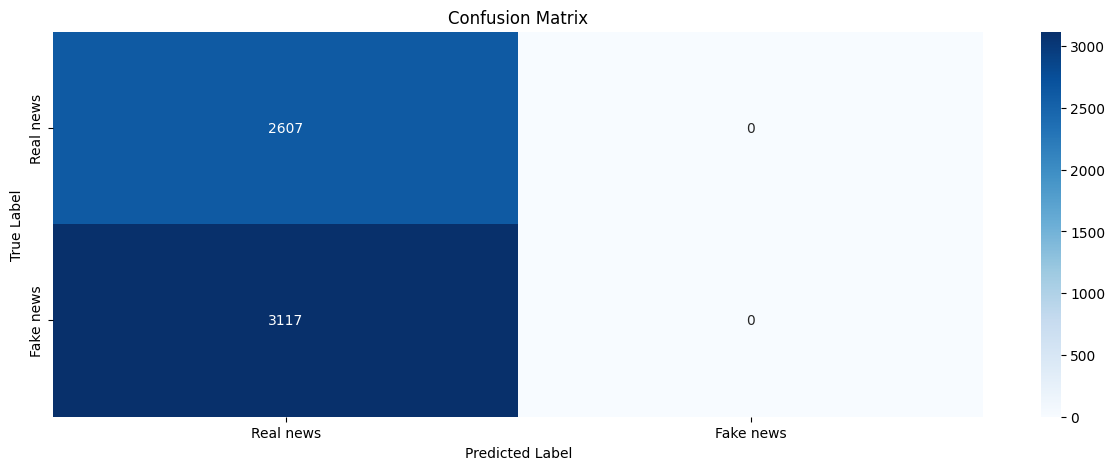

In [ ]:
plt.figure(figsize=(15, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real news', 'Fake news'], yticklabels=['Real news', 'Fake news'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Summary  
The model performance was suboptimal in this case. In some instances, the model failed to make meaningful predictions, defaulting to classifying all news as either fake or real. This suggests that increasing the number of parameters in the neural network might improve performance, as seen with the Roberta model. However, the Roberta model did not perform well in this case, indicating that simply increasing the model's complexity does not always guarantee better results.

| Name                                            | State   | Created                | Runtime | batch_size | dataset          | dropout   | epochs | learning_rate | model_name            | optimizer | warmup     | weight_decay | COMMENTS   | train_accuracy | train_f1 | train_loss  | val_accuracy | val_f1  |
|-------------------------------------------------|---------|------------------------|---------|------------|------------------|-----------|--------|----------------|-----------------------|-----------|------------|--------------|------------|-----------------|----------|-------------|--------------|---------|
| training_Fake news comments_trial_0             | finished| 2025-01-15T05:48:45.000Z | 1135    | 12         | X_train_cleaned_2| 0.2769436 | 3      | 5.00E-07       | distilbert-base-uncased| SGD       | 0.081039855| 0.005        | Experiment | 0.514449418     | 0.36098  | 0.701679926 | 0.528127193  | 0.38822 |
| training_Fake news comments_trial_1             | finished| 2025-01-15T06:07:55.000Z | 1126    | 12         | X_train_cleaned_2| 0.1197252 | 3      | 5.00E-07       | distilbert-base-uncased| AdamW     | 0.141962426| 1.00E-12     | Experiment | 0.506103635     | 0.31437  | 0.701502811 | 0.519741416  | 0.30633 |
| training_Fake news comments_trial_2             | finished| 2025-01-15T06:26:45.000Z | 1134    | 12         | X_train_cleaned_2| 0.1833687 | 3      | 7.50E-07       | distilbert-base-uncased| SGD       | 0.035504156| 0.0025       | Experiment | 0.509093165     | 0.29284  | 0.701428181 | 0.519217312  | 0.30399 |
| training_Fake news comments_trial_3             | finished| 2025-01-15T06:45:44.000Z | 1136    | 12         | X_train_cleaned_2| 0.1353568 | 3      | 5.00E-07       | distilbert-base-uncased| RMSprop   | 0.146859653| 1.00E-12     | Experiment | 0.507473826     | 0.25452  | 0.701262307 | 0.501048207  | 0.21538 |
| training_Fake news comments_trial_4             | finished| 2025-01-15T07:04:44.000Z | 1132    | 12         | X_train_cleaned_2| 0.1769652 | 3      | 5.00E-07       | distilbert-base-uncased| SGD       | 0.09996852 | 1.00E-12     | Experiment | 0.503363252     | 0.22837  | 0.701192983 | 0.50139761   | 0.21507 |
| training_Fake news comments_trial_9             | finished| 2025-01-15T08:39:27.000Z | 1136    | 12         | X_train_cleaned_2| 0.2961417 | 3      | 0.000001       | distilbert-base-uncased| SGD       | 0.141364795| 0.01         | Experiment | 0.505854487     | 0.22806  | 0.701181138 | 0.500873506  | 0.20617 |
| training_Fake news comments_trial_8             | finished| 2025-01-15T08:20:32.000Z | 1131    | 12         | X_train_cleaned_2| 0.1755216 | 3      | 1.00E-10       | distilbert-base-uncased| RMSprop   | 0.16059203 | 0.005        | Experiment | 0.499750882     | 0.21470  | 0.701123475 | 0.500698805  | 0.20611 |
| training_Fake news comments_trial_5             | finished| 2025-01-15T07:23:41.000Z | 1130    | 12         | X_train_cleaned_2| 0.2303222 | 3      | 2.50E-07       | distilbert-base-uncased| RMSprop   | 0.081032621| 0.01         | Experiment | 0.503238678     | 0.22533  | 0.70116198  | 0.500524104  | 0.20605 |
| training_Fake news comments_trial_6             | finished| 2025-01-15T07:42:36.000Z | 1136    | 12         | X_train_cleaned_2| 0.1965227 | 3      | 1.00E-10       | distilbert-base-uncased| RMSprop   | 0.101228818| 0.01         | Experiment | 0.502615869     | 0.22027  | 0.701148994 | 0.500698805  | 0.20567 |
| training_Fake news comments_trial_7             | finished| 2025-01-15T08:01:36.000Z | 1132    | 12         | X_train_cleaned_2| 0.2007332 | 3      | 1.00E-10       | distilbert-base-uncased| AdamW     | 0.125045239| 1.00E-12     | Experiment | 0.499128044     | 0.21998  | 0.701178955 | 0.500698805  | 0.20523 |
| training_Fake news comments_trial_10            | finished| 2025-01-15T08:58:28.000Z | 1135    | 12         | X_train_cleaned_2| 0.1094253 | 3      | 0.000001       | distilbert-base-uncased| AdamW     | 0.195202427| 0.0025       | Experiment | 0.49539113      | 0.17478  | 0.700923641 | 0.482180297  | 0.10991 |
| training_Fake news comments_trial_11            | finished| 2025-01-15T09:17:28.000Z | 1135    | 12         | X_train_cleaned_2| 0.2771423 | 3      | 7.50E-07       | distilbert-base-uncased| AdamW     | 0.055132472| 0.005        | Experiment | 0.467862487     | 0.04813  | 0.700245871 | 0.4592942    | 0.01527 |
| training_Fake news comments_trial_19            | finished| 2025-01-15T11:49:23.000Z | 1128    | 12         | X_train_cleaned_2| 0.2112393 | 3      | 5.00E-07       | distilbert-base-uncased| SGD       | 0.199320376| 0.005        | Experiment | 0.456651717     | 0         | 0.69634381  | 0.455450743  | 0       |
| training_Fake news comments_trial_18            | finished| 2025-01-15T11:30:31.000Z | 1127    | 12         | X_train_cleaned_2| 0.2545617 | 3      | 2.50E-07       | distilbert-base-uncased| AdamW     | 0.127605763| 1.00E-12     | Experiment | 0.456651717     | 0         | 0.696405458 | 0.45492661   | 0       |
| training_Fake news comments_trial_17            | finished| 2025-01-15T11:11:36.000Z | 1129    | 12         | X_train_cleaned_2| 0.2352918 | 3      | 7.50E-07       | distilbert-base-uncased| SGD       | 0.08214636 | 0.005        | Experiment | 0.456651717     | 0         | 0.696431109 | 0.455276042  | 0       |
| training_Fake news comments_trial_16            | finished| 2025-01-15T10:52:35.000Z | 1136    | 12         | X_train_cleaned_2| 0.1538771 | 3      | 5.00E-07       | distilbert-base-uncased| AdamW     | 0.034263325| 0.0025       | Experiment | 0.456776291     | 0.00046  | 0.696755559 | 0.454577208  | 0       |
| training_Fake news comments_trial_15            | finished| 2025-01-15T10:33:34.000Z | 1136    | 12         | X_train_cleaned_2| 0.1128018 | 3      | 2.50E-07       | distilbert-base-uncased| AdamW     | 0.114282284| 0.0075       | Experiment | 0.456651717     | 0         | 0.697395077 | 0.455276042  | 0       |
| training_Fake news comments_trial_14            | finished| 2025-01-15T10:14:32.000Z | 1137    | 12         | X_train_cleaned_2| 0.2314794 | 3      | 7.50E-07       | distilbert-base-uncased| SGD       | 0.067098841| 0.0075       | Experiment | 0.456776291     | 0.00046  | 0.697414151 | 0.455625445  | 0       |
| training_Fake news comments_trial_13            | finished| 2025-01-15T09:55:34.000Z | 1134    | 12         | X_train_cleaned_2| 0.1403614 | 3      | 5.00E-07       | distilbert-base-uncased| SGD       | 0.173520066| 0.0025       | Experiment | 0.456776291     | 0.00046  | 0.697410841 | 0.455450743  | 0       |
| training_Fake news comments_trial_12            | finished| 2025-01-15T09:36:27.000Z | 1142    | 12         | X_train_cleaned_2| 0.2534333 | 3      | 2.50E-07       | distilbert-base-uncased| AdamW     | 0.006714391| 0.0075       | Experiment | 0.457025409     | 0.00137  | 0.698208843 | 0.455625445  | 0       |

So we will discard all these models.